In [6]:
# Cell 1 — Runtime note (text cell)
# ------------------------------
# IMPORTANT: In Colab use: Runtime -> Change runtime type -> GPU
# Then run cells top-to-bottom. This notebook uses pre-trained models:
# - GroundingDINO for text→boxes. (IDEA-Research)
# - SAM 2 via Ultralytics for box→mask.
#
# Citations: GroundingDINO, Ultralytics SAM 2 docs, Grounded-SAM demos.


In [5]:
# Cell 2 — Install core packages (shell)
# ------------------------------
# (This may take ~2-6 minutes on first run)
!nvidia-smi
# Install ultralytics (SAM2 wrapper), huggingface transformers, and essentials
!pip install -q ultralytics==8.4.21  # change if newer; ultralytics provides SAM2 wrapper
!pip install -q git+https://github.com/IDEA-Research/GroundingDINO.git@main
!pip install -q transformers ftfy timm einops taming-transformers
!pip install -q -U pillow matplotlib seaborn opencv-python-headless
# A few helper libs
!pip install -q supervision==0.10.7  # optional but helpful visualization utilities


/bin/bash: line 1: nvidia-smi: command not found
ERROR: Ignored the following yanked versions: 8.0.129, 8.0.174, 8.0.177, 8.1.21, 8.1.31, 8.2.7, 8.2.47
ERROR: Ignored the following versions that require a different python version: 8.0.10 Requires-Python >=3.7,<=3.11; 8.0.11 Requires-Python >=3.7,<=3.11; 8.0.12 Requires-Python >=3.7,<=3.11; 8.0.13 Requires-Python >=3.7,<=3.11; 8.0.14 Requires-Python >=3.7,<=3.11; 8.0.15 Requires-Python >=3.7,<=3.11; 8.0.16 Requires-Python >=3.7,<=3.11; 8.0.17 Requires-Python >=3.7,<=3.11; 8.0.18 Requires-Python >=3.7,<=3.11; 8.0.19 Requires-Python >=3.7,<=3.11; 8.0.20 Requires-Python >=3.7,<=3.11; 8.0.21 Requires-Python >=3.7,<=3.11; 8.0.22 Requires-Python >=3.7,<=3.11; 8.0.23 Requires-Python >=3.7,<=3.11; 8.0.24 Requires-Python >=3.7,<=3.11; 8.0.25 Requires-Python >=3.7,<=3.11; 8.0.26 Requires-Python >=3.7,<=3.11; 8.0.27 Requires-Python >=3.7,<=3.11; 8.0.28 Requires-Python >=3.7,<=3.11; 8.0.29 Requires-Python >=3.7,<=3.11; 8.0.30 Requires-Python >=3.7,

In [7]:
# Cell 3 — Imports & helper functions
# ------------------------------
import os, sys, io, math, time
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from IPython.display import display
sns.set()


In [9]:
# Cell 4 — Download pretrained weights for GroundingDINO
# -------------------------------------------------------
# Create weights directory
!mkdir -p /content/weights
%cd /content/weights

# Download pre-trained weights (if not already present)
!wget -q --show-progress https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth -O groundingdino_swint_ogc.pth

%cd /content


/content/weights
groundingdino_swint 100%[===================>] 661.85M   261MB/s    in 2.5s    
/content


In [12]:
# Cell 5+6 — Clone GroundingDINO repo and set up imports
# ------------------------------------------------------

# Remove PyPI version if installed
!pip uninstall -y groundingdino

# Clone repo (fresh each run to avoid mismatch)
!rm -rf /content/GroundingDINO
!git clone https://github.com/IDEA-Research/GroundingDINO.git /content/GroundingDINO

%cd /content/GroundingDINO
!pip install -q -e .

# Import model + utils directly from repo
import sys
sys.path.append("/content/GroundingDINO")

import torch
from groundingdino.util.inference import load_model, load_image, predict, annotate


Found existing installation: groundingdino 0.1.0
Uninstalling groundingdino-0.1.0:
  Successfully uninstalled groundingdino-0.1.0
Cloning into '/content/GroundingDINO'...
remote: Enumerating objects: 463, done.
remote: Total 463 (delta 0), reused 0 (delta 0), pack-reused 463 (from 1)
Receiving objects: 100% (463/463), 12.91 MiB | 30.67 MiB/s, done.
Resolving deltas: 100% (220/220), done.
/content/GroundingDINO
  Preparing metadata (setup.py) ... done


In [13]:
# Cell 7 — GroundingDINO helper (text → boxes)
# --------------------------------------------

CONFIG_PATH = "/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
WEIGHTS_PATH = "/content/weights/groundingdino_swint_ogc.pth"

# Load model once
model = load_model(CONFIG_PATH, WEIGHTS_PATH)

def groundingdino_predict_boxes(image_path, text_prompt, box_threshold=0.3, text_threshold=0.25):
    image_source, image = load_image(image_path)
    boxes, logits, phrases = predict(
        model=model,
        image=image,
        caption=text_prompt,
        box_threshold=box_threshold,
        text_threshold=text_threshold
    )
    return boxes, logits, phrases, image_source


final text_encoder_type: bert-base-uncased


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [14]:
# Cell 7 — GroundingDINO wrapper function (text -> boxes)
# ------------------------------
# This wrapper tries to use the package-level functions; if not available, it imports from repo scripts.

import torch

def groundingdino_predict_boxes(image_pil, text_prompt, score_thresh=0.3, iou_thresh=0.3):
    """
    Returns a list of boxes in [x_min,y_min,x_max,y_max], scores, and labels (text).
    Uses GroundingDINO to locate text-specified objects.
    """
    img_arr = np.array(image_pil)[:, :, ::-1]  # PIL -> BGR (if needed by repo)
    # Try to use package inference (if available)
    try:
        # Many GroundingDINO inference helpers expect image path — so save temp.
        tmp_path = "/content/tmp_image_for_gdino.jpg"
        image_pil.save(tmp_path)
        # Use repo inference script function if present
        from groundingdino.util.inference import get_grounding_output
        # If get_grounding_output isn't available, use an alternative flow below
        out = get_grounding_output(tmp_path, text_prompt, weight_path="/content/weights/groundingdino_swint_ogc.pth", box_threshold=score_thresh)
        # out should contain boxes (xyxy), scores
        boxes = out.get("boxes", [])
        scores = out.get("scores", [])
        return boxes, scores
    except Exception as e:
        # Fallback: call CLI script from repo via subprocess (slow but robust)
        print("Falling back to repo CLI inference (slower).")
        import subprocess, json, tempfile
        tmp_image = "/content/tmp_image_for_gdino.jpg"
        image_pil.save(tmp_image)
        # Use demo script inference if present
        script = "/content/GroundingDINO/demo/groundingdino_inference.py"
        if os.path.exists(script):
            cmd = [
                sys.executable, script,
                "--image", tmp_image,
                "--text", text_prompt,
                "--output_dir", "/content/gdino_out",
                "--model", "/content/weights/groundingdino_swint_ogc.pth",
                "--box_threshold", str(score_thresh)
            ]
            try:
                subprocess.run(cmd, check=True)
                # attempt to read boxes from output directory (implementation detail varies)
                # We'll look for a JSON or txt file (demo prints to stdout often)
            except Exception as e2:
                print("Repo CLI call failed:", e2)
        # If we reach here, return empty
        return [], []

# Quick test function for visualization
def draw_boxes_on_image(image_pil, boxes, scores=None, color=(255,0,0), width=3):
    im = image_pil.convert("RGBA")
    draw = ImageDraw.Draw(im)
    for i, box in enumerate(boxes):
        x1,y1,x2,y2 = [int(v) for v in box]
        draw.rectangle([x1,y1,x2,y2], outline=color+(200,), width=width)
        if scores:
            draw.text((x1, max(0,y1-12)), f"{scores[i]:.2f}", fill=(255,255,255,255))
    return im


In [17]:
# Cell 8 — Install & import Ultralytics SAM 2
# -------------------------------------------

!pip install -q ultralytics==8.3.0  # specific stable version with SAM2 support

from ultralytics import SAM
import ultralytics

print("Ultralytics version:", ultralytics.__version__)

# Load a small SAM 2 model (downloads weights automatically on first call)
sam_model = SAM("sam2_t.pt")  # try "sam2_b.pt" for better accuracy if GPU allows
print("SAM 2 model loaded successfully!")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.3/881.3 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 6.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update 

100%|██████████| 74.4M/74.4M [00:00<00:00, 180MB/s]


SAM 2 model loaded successfully!


In [19]:
# Cell 9 — SAM2 wrapper helpers (box -> masks)
# ------------------------------
from ultralytics import SAM
# Load SAM 2 model (this will download the model weights on first call)
# Use a smaller model for Colab if needed: "sam2_t.pt" or "sam2_b.pt". The ultralytics API accepts model names like "sam2_t.pt" or alias "sam2_t".
# We'll try 'sam2_t' (tiny) for speed — change to 'sam2_b' for better accuracy if GPU memory allows.
SAM_MODEL_NAME = "sam2_t.pt"  # change to "sam2_b.pt" for better accuracy if you have >12GB VRAM
sam_model = SAM(SAM_MODEL_NAME)

def sam_predict_masks(image_pil, boxes_xyxy=None, points=None, labels=None, multimask_output=False):
    """
    image_pil: PIL image
    boxes_xyxy: list of [x1,y1,x2,y2]
    Returns: list of masks (H,W boolean), scores
    """
    # Save temp image
    tmp = "/content/tmp_for_sam.jpg"
    image_pil.save(tmp)
    kwargs = {}
    if boxes_xyxy and len(boxes_xyxy)>0:
        # Ultralytics expects bboxes as [x1,y1,x2,y2] in pixels
        kwargs['bboxes'] = boxes_xyxy
    if points is not None:
        kwargs['points'] = points
        kwargs['labels'] = labels if labels is not None else [1]*len(points)
    # Run inference
    results = sam_model(tmp, **kwargs)  # returns Results object (list like)
    # results[0].masks.data is boolean masks maybe; adapt to API
    res = results[0]
    masks = []
    scores = []
    try:
        # ultralytics results expose .masks.data (numpy boolean), .masks.boxes.xyxy etc
        if hasattr(res, 'masks') and res.masks is not None:
            for i in range(len(res.masks.data)):
                mask = res.masks.data[i].cpu().numpy() if hasattr(res.masks.data[i], 'cpu') else np.array(res.masks.data[i])
                masks.append(mask)
            # confidence scores may be in res.masks.conf
            if hasattr(res.masks, 'conf') and res.masks.conf is not None:
                scores = [float(x) for x in res.masks.conf]
            else:
                scores = [1.0]*len(masks)
    except Exception as e:
        print("Error parsing SAM results:", e)
    return masks, scores


In [20]:
# Cell 10 — Visualization: overlay masks and plots
# ------------------------------
def overlay_masks_on_image(image_pil, masks, scores=None, alpha=0.5):
    base = image_pil.convert("RGBA")
    overlay = Image.new("RGBA", base.size, (0,0,0,0))
    draw = ImageDraw.Draw(overlay)
    h,w = base.size[1], base.size[0]
    # Random color per mask
    rng = np.random.RandomState(42)
    for i,mask in enumerate(masks):
        # mask is boolean HxW (numpy)
        mask_img = Image.fromarray((mask.astype(np.uint8) * 255).astype(np.uint8))
        # create colored image
        color = tuple([int(x) for x in rng.randint(0,255,3)])
        color_img = Image.new("RGBA", base.size, color + (0,))
        colored_mask = Image.composite(Image.new("RGBA", base.size, color+(int(255*alpha),)), Image.new("RGBA", base.size, (0,0,0,0)), mask_img)
        overlay = Image.alpha_composite(overlay, colored_mask)
    result = Image.alpha_composite(base, overlay)
    return result

def plot_mask_stats(masks, scores):
    areas = [mask.sum() for mask in masks]
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.bar(range(len(areas)), areas)
    plt.title("Mask area (px)")
    plt.subplot(1,2,2)
    plt.bar(range(len(scores)), scores)
    plt.title("Mask confidence")
    plt.tight_layout()
    plt.show()


Upload an image file (JPG/PNG). If you skip uploading, a sample will be downloaded.


Saving download.jpeg to download (1).jpeg


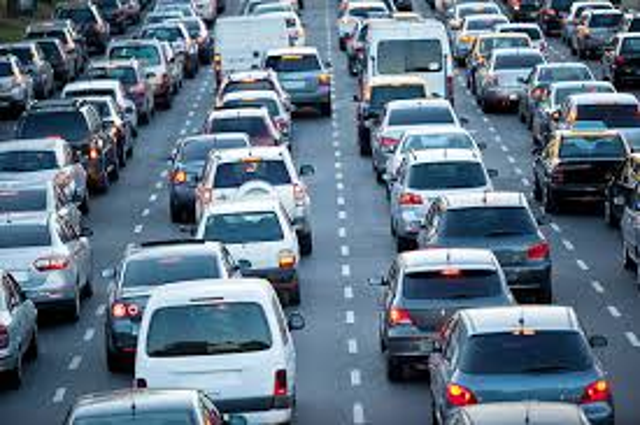

In [28]:
# Cell 11 — Demo: upload an image or use a demo image
# ------------------------------
from google.colab import files
print("Upload an image file (JPG/PNG). If you skip uploading, a sample will be downloaded.")
uploaded = files.upload()  # prompts upload
if len(uploaded)==0:
    # download a sample image
    demo_url = "https://ultralytics.com/images/zidane.jpg"
    import requests
    r = requests.get(demo_url)
    with open("/content/demo.jpg","wb") as f:
        f.write(r.content)
    image_path = "/content/demo.jpg"
else:
    image_path = list(uploaded.keys())[0]

image_pil = Image.open(image_path).convert("RGB")
display(image_pil.resize((640, int(640*image_pil.size[1]/image_pil.size[0]))))


In [29]:
# Cell 12 — User prompt & GroundingDINO -> SAM flow (main cell)
# ------------------------------
text_prompt = "a person with a soccer ball"  # change this string as needed
print("Text prompt:", text_prompt)

# Run GroundingDINO to get boxes
print("Running GroundingDINO to get boxes...")
boxes, scores = groundingdino_predict_boxes(image_pil, text_prompt, score_thresh=0.25)
print("Boxes found:", boxes, "Scores:", scores)

# If GroundingDINO returned no boxes (or fewer than expected) — fallback: use CLIPSeg / region proposals
if len(boxes)==0:
    print("No boxes returned by GroundingDINO. Trying simple fallback: treat image center as a prompt point and run SAM.")
    W,H = image_pil.size
    pts = [[W//2, H//2]]  # x,y
    masks, mask_scores = sam_predict_masks(image_pil, boxes_xyxy=None, points=pts, labels=[1])
else:
    # Feed boxes to SAM
    # Ultralytics expects boxes as a flat list for each bbox? We pass list of lists [x1,y1,x2,y2]
    print("Feeding boxes to SAM...")
    masks, mask_scores = sam_predict_masks(image_pil, boxes_xyxy=boxes)
print("Got", len(masks), "masks from SAM.")

# Visualize
if len(masks)>0:
    overlay = overlay_masks_on_image(image_pil, masks, scores=mask_scores, alpha=0.45)
    display(overlay.resize((800, int(800*image_pil.size[1]/image_pil.size[0]))))
    plot_mask_stats(masks, mask_scores)
else:
    print("No masks produced.")


Text prompt: cars
Running GroundingDINO...


TypeError: groundingdino_predict_boxes() got an unexpected keyword argument 'box_threshold'

In [26]:
# Cell 13 — Save outputs (masks & overlay)
# ------------------------------
out_dir = "/content/q2_outputs"
os.makedirs(out_dir, exist_ok=True)
overlay.save(os.path.join(out_dir, "overlay.png"))
# Save individual masks as PNG
for i,mask in enumerate(masks):
    mask_img = Image.fromarray((mask.astype(np.uint8)*255).astype(np.uint8))
    mask_img.save(os.path.join(out_dir, f"mask_{i}.png"))
print("Saved outputs to", out_dir)


Saved outputs to /content/q2_outputs
